<a href="https://colab.research.google.com/github/psyahmi/CPE-Assessment/blob/main/notebooks/05_Readiness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import requests
from io import BytesIO
from PIL import Image
import torch.nn.functional as F
from google.colab import files


In [41]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [43]:
def get_train_transforms():
    return transforms.Compose([
        transforms.RandomResizedCrop(160),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(0.2,0.2,0.2,0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

def get_eval_transforms():
    return transforms.Compose([
        transforms.Resize(176),
        transforms.CenterCrop(160),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

In [44]:
train_dataset = Flowers102(root="./data", split="train", download=True, transform=get_train_transforms())
val_dataset = Flowers102(root="./data", split="val", download=True, transform=get_eval_transforms())
test_dataset = Flowers102(root="./data", split="test", download=True, transform=get_eval_transforms())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

num_classes = 102
class_names = train_dataset.classes
print(f"Number of classes: {num_classes}")

Number of classes: 102


In [45]:
labels = torch.tensor(train_dataset._labels)  # Flowers102 uses _labels
class_counts = torch.bincount(labels)
class_weights = 1. / class_counts.float()
print("Class weights calculated.")

Class weights calculated.


In [46]:
class EfficientNetFlowers(nn.Module):
    def __init__(self, num_classes=102):
        super().__init__()
        self.model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        # Freeze backbone
        # Freeze backbone
        for param in self.model.parameters():
          param.requires_grad = False

# 🔥 FIX: Unfreeze LAST EfficientNet block for Grad-CAM
        for param in self.model.features[-1].parameters():
          param.requires_grad = True
        # Fine-tune classifier only
        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        # Initialize new layers
        for m in self.model.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None: nn.init.constant_(m.bias,0)
    def forward(self, x):
        return self.model(x)

model = EfficientNetFlowers().to(device)
print(model)

EfficientNetFlowers(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (s

In [47]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, class_weights, device, patience=5):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
        params_to_opt = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = optim.AdamW(params_to_opt, lr=1e-4, weight_decay=1e-4)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='max', factor=0.5, patience=2, min_lr=1e-7)
        self.history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[], 'lr':[]}
        self.best_val_acc = 0
        self.patience_counter = 0
        self.patience = patience
        self.best_model_state = None

    def train_epoch(self):
        self.model.train()
        total_loss, correct, total = 0,0,0
        for images, labels in self.train_loader:
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()*images.size(0)
            _,pred = torch.max(outputs,1)
            total += labels.size(0)
            correct += (pred==labels).sum().item()
        return total_loss/total, 100*correct/total

    def validate(self):
        self.model.eval()
        total_loss, correct, total = 0,0,0
        with torch.no_grad():
            for images, labels in self.val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()*images.size(0)
                _,pred = torch.max(outputs,1)
                total += labels.size(0)
                correct += (pred==labels).sum().item()
        return total_loss/total, 100*correct/total

    def train(self, num_epochs=10):
        print(f"Starting training for {num_epochs} epochs...")
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.validate()
            self.scheduler.step(val_acc)
            current_lr = self.optimizer.param_groups[0]['lr']
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['lr'].append(current_lr)
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | LR: {current_lr:.2e}")
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.patience_counter = 0
                self.best_model_state = self.model.state_dict().copy()
                torch.save({'model_state_dict':self.model.state_dict(),
                            'optimizer_state_dict':self.optimizer.state_dict(),
                            'val_acc':val_acc}, 'best_model.pth')
                print("✓ New best model saved!")
            else:
                self.patience_counter += 1
                if self.patience_counter >= self.patience:
                    print(f"⚠️ Early stopping at epoch {epoch+1}")
                    break
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
            print(f"Loaded best model (Val Acc: {self.best_val_acc:.2f}%)")
        return self.history

    def plot_history(self):
        fig, axes = plt.subplots(1,3,figsize=(15,4))
        axes[0].plot(self.history['train_loss'],label='Train'); axes[0].plot(self.history['val_loss'],label='Val')
        axes[0].set_title('Loss'); axes[0].legend(); axes[0].grid(True,alpha=0.3)
        axes[1].plot(self.history['train_acc'],label='Train'); axes[1].plot(self.history['val_acc'],label='Val')
        axes[1].set_title('Accuracy'); axes[1].legend(); axes[1].grid(True,alpha=0.3)
        axes[2].plot(self.history['lr'],marker='o',color='green')
        axes[2].set_title('Learning Rate'); axes[2].set_yscale('log'); axes[2].grid(True,alpha=0.3)
        plt.tight_layout(); plt.show()

Starting training for 10 epochs...

Epoch 1/10
Train Loss: 10.1477, Train Acc: 0.29% | Val Loss: 6.8052, Val Acc: 1.67% | LR: 1.00e-04
✓ New best model saved!

Epoch 2/10
Train Loss: 9.6463, Train Acc: 1.47% | Val Loss: 6.5096, Val Acc: 2.45% | LR: 1.00e-04
✓ New best model saved!

Epoch 3/10
Train Loss: 9.2597, Train Acc: 1.96% | Val Loss: 6.1240, Val Acc: 3.63% | LR: 1.00e-04
✓ New best model saved!

Epoch 4/10
Train Loss: 8.9029, Train Acc: 2.45% | Val Loss: 5.7437, Val Acc: 4.71% | LR: 1.00e-04
✓ New best model saved!

Epoch 5/10
Train Loss: 8.5550, Train Acc: 3.24% | Val Loss: 5.4771, Val Acc: 6.08% | LR: 1.00e-04
✓ New best model saved!

Epoch 6/10
Train Loss: 8.2199, Train Acc: 2.84% | Val Loss: 5.1589, Val Acc: 7.55% | LR: 1.00e-04
✓ New best model saved!

Epoch 7/10
Train Loss: 7.9862, Train Acc: 4.41% | Val Loss: 4.8850, Val Acc: 9.61% | LR: 1.00e-04
✓ New best model saved!

Epoch 8/10
Train Loss: 7.7427, Train Acc: 4.80% | Val Loss: 4.6299, Val Acc: 12.06% | LR: 1.00e-04
✓ N

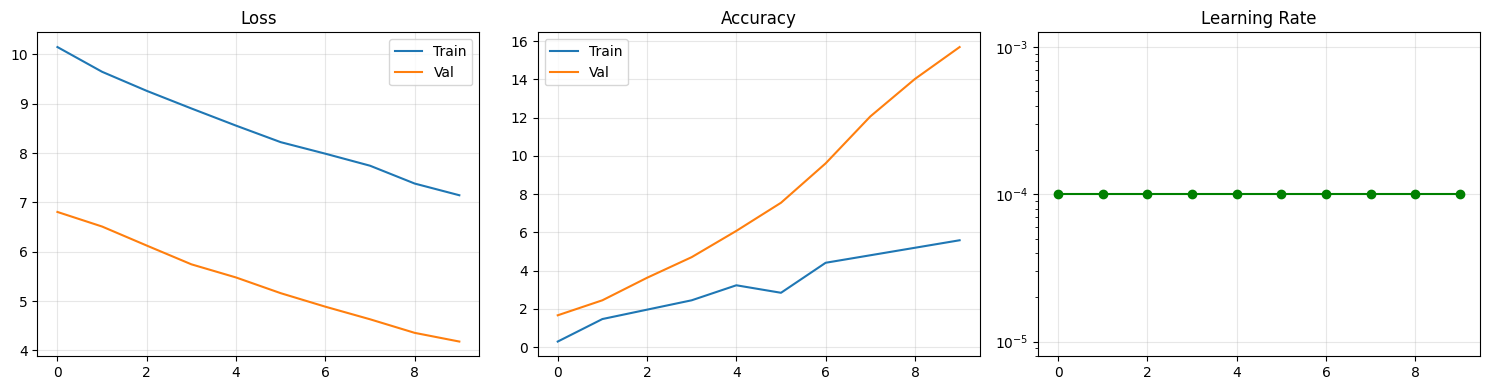

In [48]:
trainer = ModelTrainer(model, train_loader, val_loader, class_weights, device)
history = trainer.train(num_epochs=10)
trainer.plot_history()

In [49]:
checkpoint = torch.load('best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Best checkpoint loaded with val_acc: {checkpoint['val_acc']:.2f}%")

✓ Best checkpoint loaded with val_acc: 15.69%


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Evaluation Metrics ===
Accuracy: 0.1569
Precision (macro): 0.1510
Precision (weighted): 0.1510
Recall (macro): 0.1569
Recall (weighted): 0.1569
F1-score (macro): 0.1334
F1-score (weighted): 0.1334


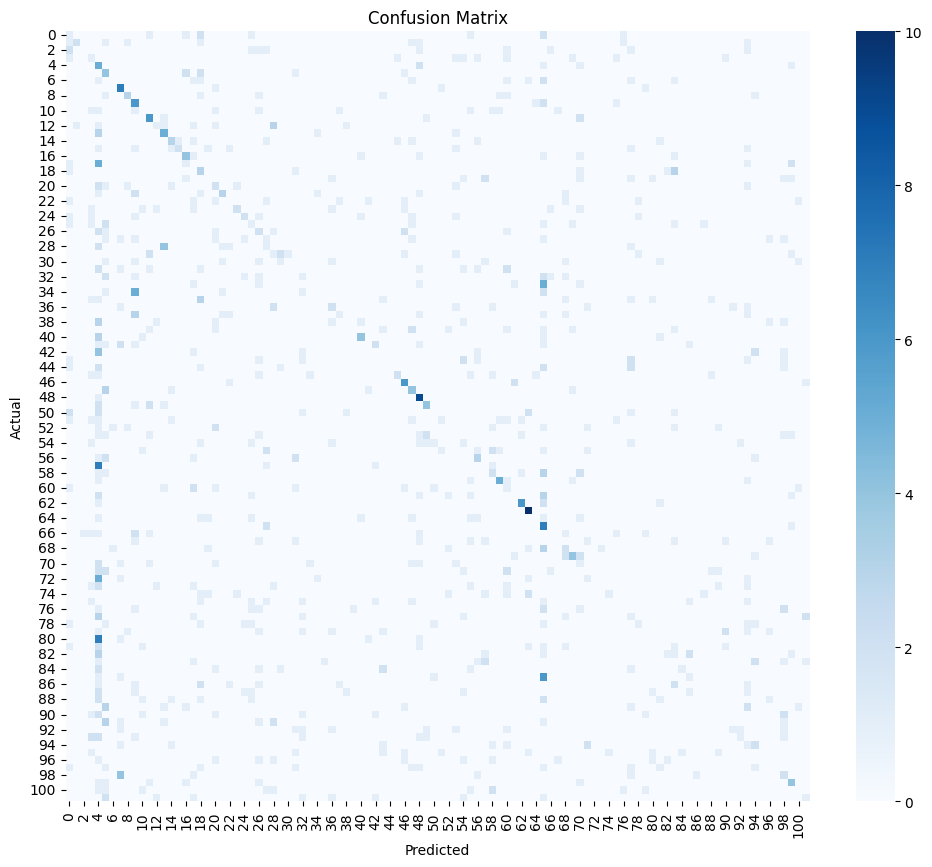

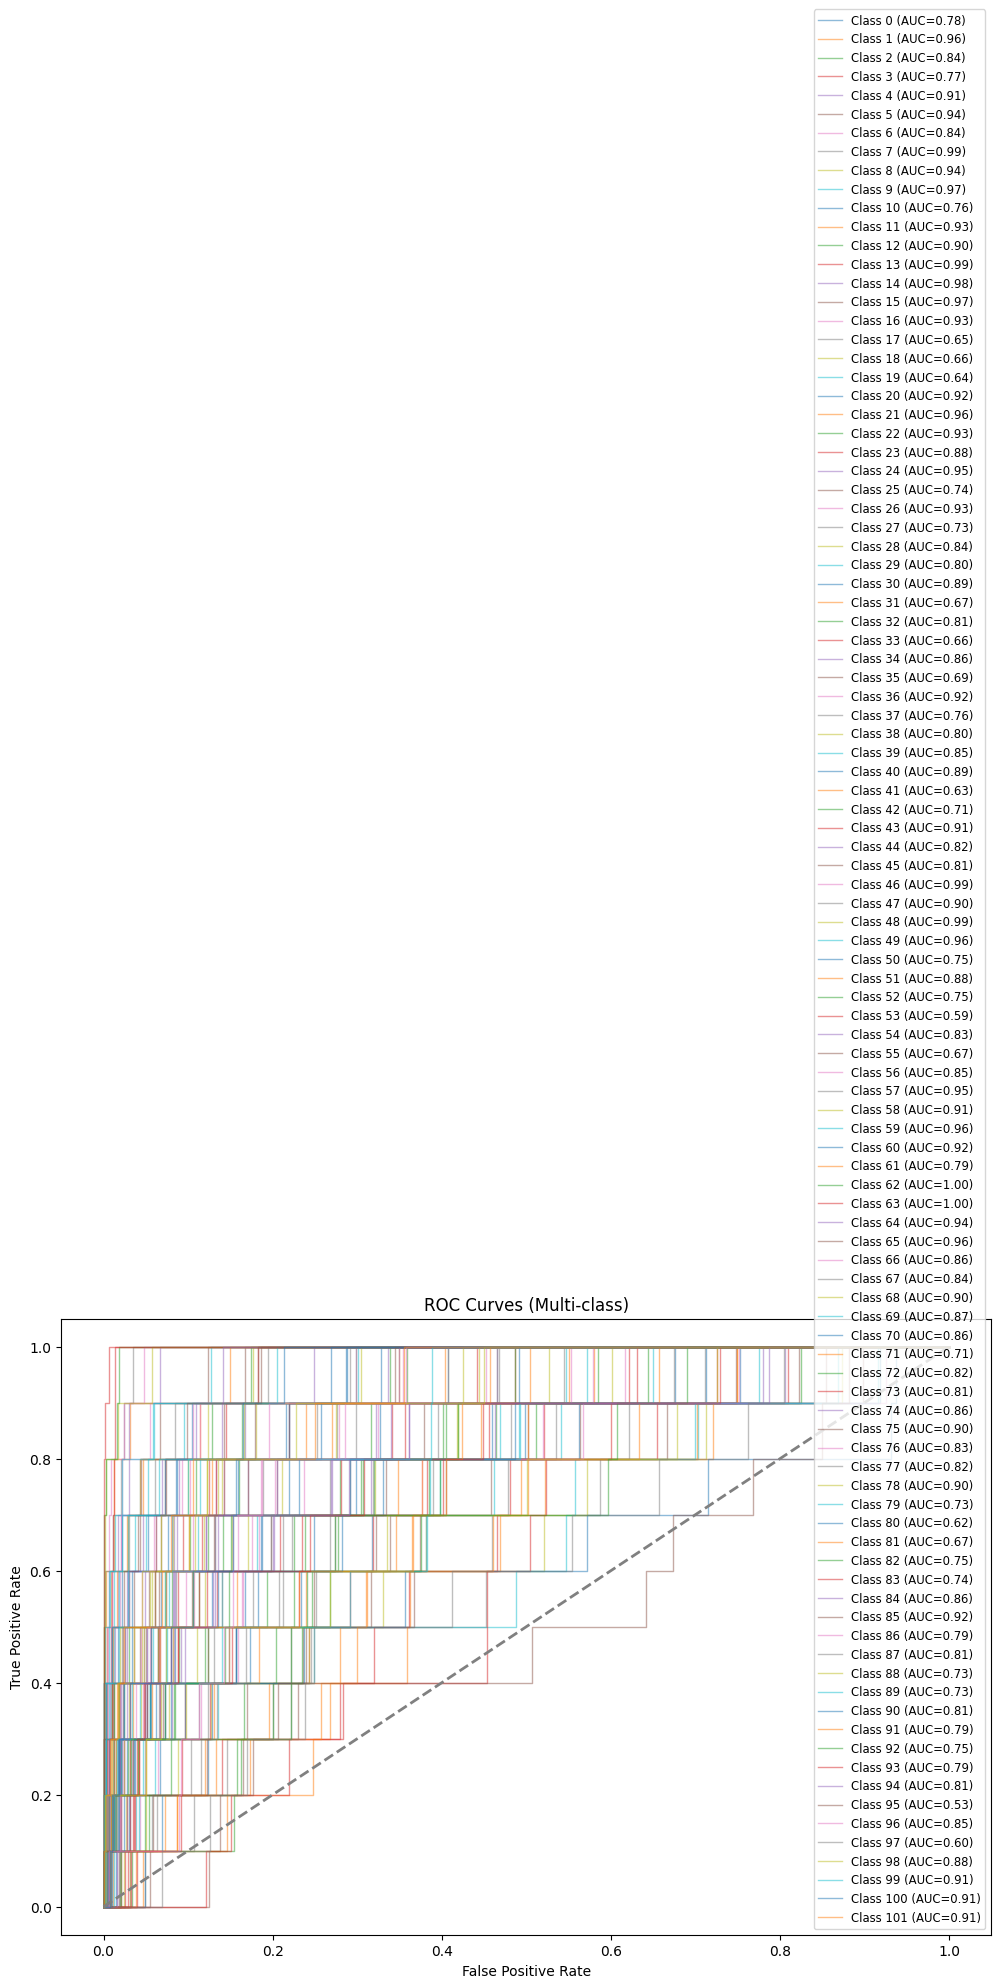

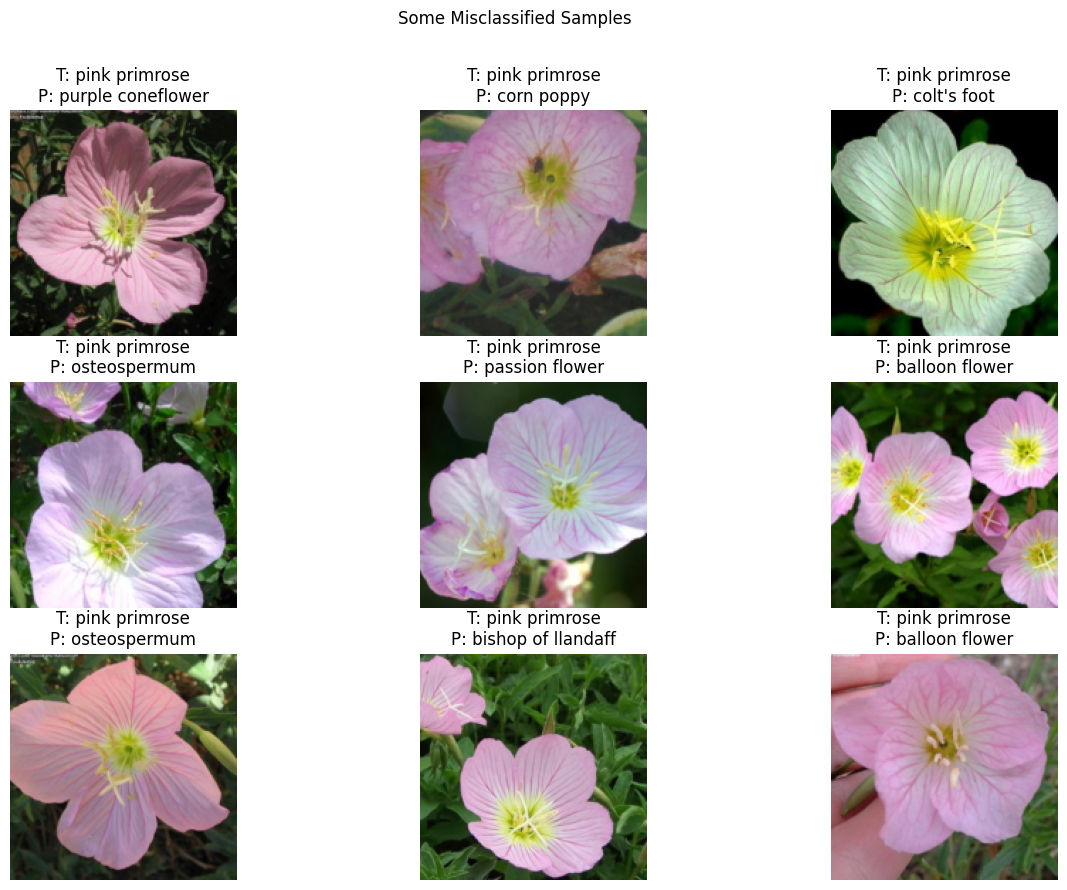

In [50]:
all_labels, all_preds, all_probs = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# ---------- Metrics ----------
accuracy = accuracy_score(all_labels, all_preds)
precision_macro = precision_score(all_labels, all_preds, average='macro')
precision_weighted = precision_score(all_labels, all_preds, average='weighted')
recall_macro = recall_score(all_labels, all_preds, average='macro')
recall_weighted = recall_score(all_labels, all_preds, average='weighted')
f1_macro = f1_score(all_labels, all_preds, average='macro')
f1_weighted = f1_score(all_labels, all_preds, average='weighted')

print("\n=== Evaluation Metrics ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Precision (weighted): {precision_weighted:.4f}")
print(f"Recall (macro): {recall_macro:.4f}")
print(f"Recall (weighted): {recall_weighted:.4f}")
print(f"F1-score (macro): {f1_macro:.4f}")
print(f"F1-score (weighted): {f1_weighted:.4f}")

# ---------- Confusion Matrix ----------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ---------- ROC Curves ----------
labels_onehot = label_binarize(all_labels, classes=range(num_classes))
plt.figure(figsize=(12,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(labels_onehot[:,i], all_probs[:,i])
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.5, label=f"Class {i} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],'--',color='gray', lw=2)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Multi-class)")
plt.legend(loc="lower right", fontsize='small')
plt.show()

# ---------- Error Analysis ----------
misclassified_idx = np.where(all_labels != all_preds)[0]
plt.figure(figsize=(15,10))
for i, idx in enumerate(misclassified_idx[:9]):
    plt.subplot(3,3,i+1)
    img = val_loader.dataset[idx][0].numpy().transpose(1,2,0)
    img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    img = np.clip(img,0,1)
    plt.imshow(img)
    plt.title(f"T: {class_names[all_labels[idx]]}\nP: {class_names[all_preds[idx]]}")
    plt.axis('off')
plt.suptitle("Some Misclassified Samples")
plt.show()

In [51]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        self.model.zero_grad()
        loss = output[0, class_idx]
        loss.backward()

        # Grad-CAM calculation
        weights = self.gradients.mean(dim=(2,3), keepdim=True)  # GAP over H,W
        cam = F.relu((weights * self.activations).sum(dim=1, keepdim=True))
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # normalize 0-1
        return cam, class_idx

In [52]:
target_layer = model.model.features[-1]

gradcam = GradCAM(model, target_layer)

True label: 0, Predicted: 65


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


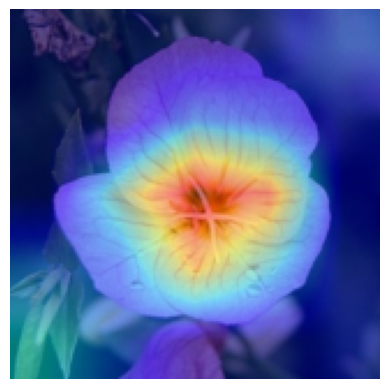

In [53]:
def show_cam_on_image(img_tensor, cam):
    img = img_tensor.squeeze().permute(1,2,0).cpu().numpy()
    img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.show()

# Example usage on first test sample
sample_img, sample_label = test_dataset[0]
input_tensor = sample_img.unsqueeze(0).to(device)
cam, pred_class = gradcam.generate_cam(input_tensor)

print(f"True label: {sample_label}, Predicted: {pred_class}")
show_cam_on_image(input_tensor, cam)

In [54]:
correct_samples = []
incorrect_samples = []

for i, (img, label) in enumerate(test_dataset):
    input_tensor = img.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        pred = output.argmax(dim=1).item()

    if pred == label and len(correct_samples) < 5:
        correct_samples.append((img, label, pred))
    elif pred != label and len(incorrect_samples) < 5:
        incorrect_samples.append((img, label, pred))

    if len(correct_samples) >= 5 and len(incorrect_samples) >= 5:
        break

In [55]:
def visualize_gradcam(samples, gradcam, title):
    print(f"\n=== {title} ===")
    for img, label, pred in samples:
        input_tensor = img.unsqueeze(0).to(device)
        cam, pred_class = gradcam.generate_cam(input_tensor)
        print(f"True Label: {label}, Predicted: {pred_class}")
        show_cam_on_image(input_tensor, cam)


=== Correctly Classified Samples ===
True Label: 0, Predicted: 0


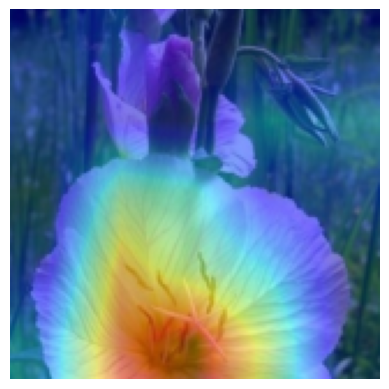

True Label: 0, Predicted: 0


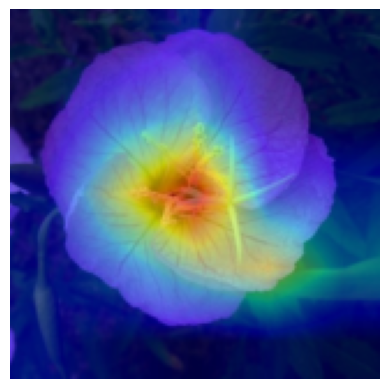

True Label: 1, Predicted: 1


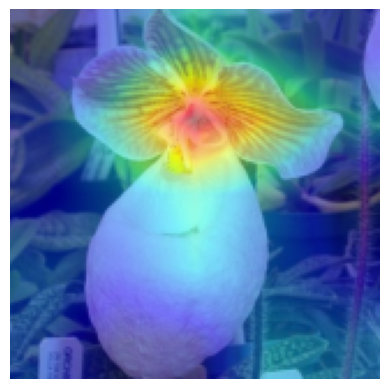

True Label: 1, Predicted: 1


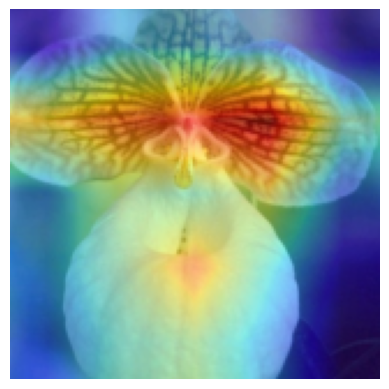

True Label: 1, Predicted: 1


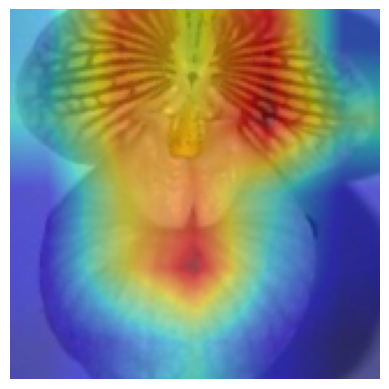

In [56]:
visualize_gradcam(correct_samples, gradcam, "Correctly Classified Samples")


=== Misclassified Samples ===
True Label: 0, Predicted: 65


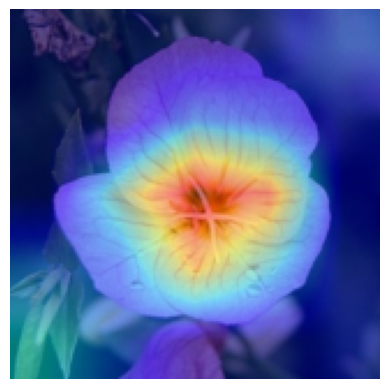

True Label: 0, Predicted: 4


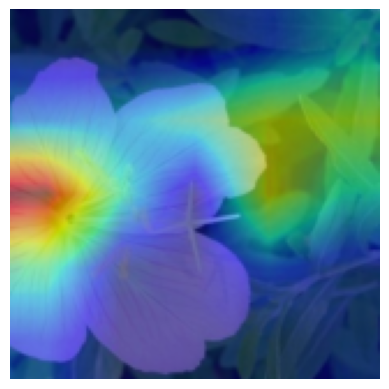

True Label: 0, Predicted: 68


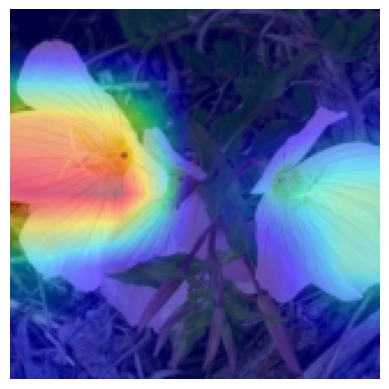

True Label: 0, Predicted: 65


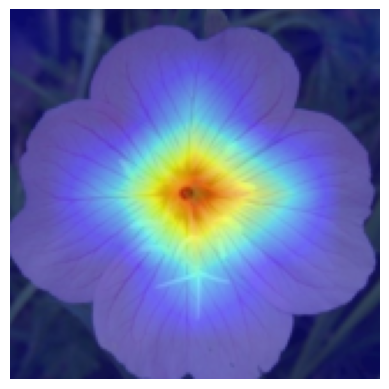

True Label: 0, Predicted: 61


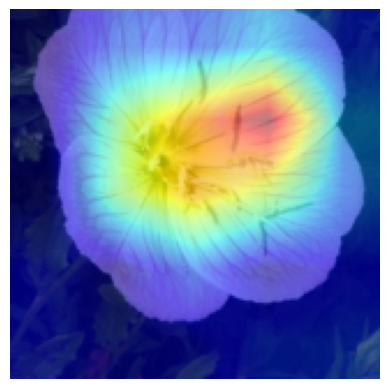

In [57]:
visualize_gradcam(incorrect_samples, gradcam, "Misclassified Samples")

In [65]:
uploaded = files.upload()

Saving flower-8095738_1280.jpg to flower-8095738_1280.jpg


In [67]:
preprocess = get_eval_transforms()

def predict_image(image_path_or_url):
    """Predict class and top-3 predictions for a single image."""

    # Load image (local path or URL)
    if image_path_or_url.startswith('http'):
        import requests
        from io import BytesIO
        response = requests.get(image_path_or_url)
        img = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        img = Image.open(image_path_or_url).convert('RGB')

    # Preprocess
    input_tensor = preprocess(img).unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)

    # Predictions
    conf, pred_idx = torch.max(probs, 1)
    top3_probs, top3_idx = torch.topk(probs, k=3)

    # Convert to readable format
    pred_class = class_names[pred_idx.item()]
    top3_predictions = [(class_names[i.item()], p.item()) for i, p in zip(top3_idx[0], top3_probs[0])]

    return {
        "predicted_class": pred_class,
        "confidence": conf.item(),
        "top3_predictions": top3_predictions
    }

# Step 3: Predict
result = predict_image(image_path)

print("Predicted class:", result["predicted_class"])
print("Confidence score:", result["confidence"])
print("Top-3 predictions:", result["top3_predictions"])

Predicted class: english marigold
Confidence score: 0.21098554134368896
Top-3 predictions: [('english marigold', 0.21098554134368896), ('sunflower', 0.15596970915794373), ('geranium', 0.07788728177547455)]
